In [26]:
import numpy as np 
from shapely.ops import split  
import geopandas as gpd  
from shapely.geometry import MultiPolygon, Polygon, LineString   
import ee
import requests
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import shutil

In [27]:
geo_filepath = "./shapefiles/nombre_shapefile.shp"

In [28]:
GeoDF = gpd.read_file(geo_filepath)


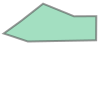

In [29]:
G = np.random.choice(GeoDF.geometry.values)
G

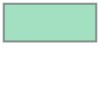

In [30]:
Rectangle = G.envelope
Rectangle

In [31]:

side_length = 0.02


rect_coords = np.array(Rectangle.boundary.coords.xy)


y_list = rect_coords[1]
x_list = rect_coords[0]


y1 = min(y_list)
y2 = max(y_list)


x1 = min(x_list)
x2 = max(x_list)


width = x2 - x1
height = y2 - y1


xcells = int(np.round(width / side_length))
ycells = int(np.round(height / side_length))

yindices = np.linspace(y1, y2, ycells + 1)
xindices = np.linspace(x1, x2, xcells + 1)
width,height


(0.337169585456806, 0.13762882422256695)

In [32]:

horizontal_splitters = [
    LineString([(x, yindices[0]), (x, yindices[-1])]) for x in xindices
]


horizontal_splitters

[<LINESTRING (-72.975 -36.772, -72.975 -36.634)>,
 <LINESTRING (-72.955 -36.772, -72.955 -36.634)>,
 <LINESTRING (-72.935 -36.772, -72.935 -36.634)>,
 <LINESTRING (-72.915 -36.772, -72.915 -36.634)>,
 <LINESTRING (-72.895 -36.772, -72.895 -36.634)>,
 <LINESTRING (-72.875 -36.772, -72.875 -36.634)>,
 <LINESTRING (-72.856 -36.772, -72.856 -36.634)>,
 <LINESTRING (-72.836 -36.772, -72.836 -36.634)>,
 <LINESTRING (-72.816 -36.772, -72.816 -36.634)>,
 <LINESTRING (-72.796 -36.772, -72.796 -36.634)>,
 <LINESTRING (-72.776 -36.772, -72.776 -36.634)>,
 <LINESTRING (-72.756 -36.772, -72.756 -36.634)>,
 <LINESTRING (-72.737 -36.772, -72.737 -36.634)>,
 <LINESTRING (-72.717 -36.772, -72.717 -36.634)>,
 <LINESTRING (-72.697 -36.772, -72.697 -36.634)>,
 <LINESTRING (-72.677 -36.772, -72.677 -36.634)>,
 <LINESTRING (-72.657 -36.772, -72.657 -36.634)>,
 <LINESTRING (-72.637 -36.772, -72.637 -36.634)>]

In [33]:

vertical_splitters = [
    LineString([(xindices[0], y), (xindices[-1], y)]) for y in yindices
]


vertical_splitters

[<LINESTRING (-72.975 -36.772, -72.637 -36.772)>,
 <LINESTRING (-72.975 -36.752, -72.637 -36.752)>,
 <LINESTRING (-72.975 -36.732, -72.637 -36.732)>,
 <LINESTRING (-72.975 -36.713, -72.637 -36.713)>,
 <LINESTRING (-72.975 -36.693, -72.637 -36.693)>,
 <LINESTRING (-72.975 -36.673, -72.637 -36.673)>,
 <LINESTRING (-72.975 -36.654, -72.637 -36.654)>,
 <LINESTRING (-72.975 -36.634, -72.637 -36.634)>]

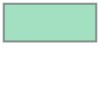

In [34]:
result = Rectangle

result

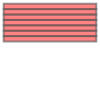

In [35]:
for splitter in vertical_splitters:
    result = MultiPolygon(split(result, splitter))

result

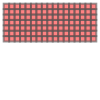

In [36]:
for splitter in horizontal_splitters:
    result = MultiPolygon(split(result, splitter))

result


In [37]:
square_polygons = list(result.geoms)
len(square_polygons)


119

In [38]:
df = gpd.GeoDataFrame(square_polygons)


In [39]:
SquareGeoDF  = gpd.GeoDataFrame(square_polygons).rename(columns={0: "geometry"})

In [40]:
SquareGeoDF = gpd.GeoDataFrame(square_polygons)

SquareGeoDF = SquareGeoDF.set_geometry(0)


In [41]:
Geoms = SquareGeoDF[SquareGeoDF.intersects(G)].geometry.values
shape = "square"
thresh = 0.9

In [42]:
if shape == "rhombus":
    geoms = [g for g in Geoms if ((g.intersection(G)).area / g.area) >= thresh]
elif shape == "square":
    geoms = [g for g in Geoms if ((g.intersection(G)).area / g.area) >= thresh]

geoms
len(geoms)

62

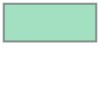

In [43]:
Rectangle

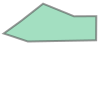

In [44]:
G

In [45]:
def crear_archivo_shapefile(geometry, nombre):

    #print(geometry)
    polygon = Polygon(tuple(geometry))

    gdf = gpd.GeoDataFrame({'geometry': [polygon]})


    directorio = './shapefileSubimagen/'+ nombre+'/'
    
    if not os.path.exists(directorio):
        os.makedirs(directorio)

    ruta_guardar = './shapefileSubimagen/'+ nombre+'/' + nombre +'.shp'

    gdf.to_file(ruta_guardar)

    #print(f'Shapefile guardado en: {ruta_guardar}')
    return ruta_guardar

In [46]:
def eliminar_contenido_carpeta(carpeta_a_eliminar ):
    if os.path.exists(carpeta_a_eliminar):
        for contenido in os.listdir(carpeta_a_eliminar):
            contenido_ruta = os.path.join(carpeta_a_eliminar, contenido)
            if os.path.isfile(contenido_ruta):
                os.remove(contenido_ruta)      
            elif os.path.isdir(contenido_ruta):
                shutil.rmtree(contenido_ruta)
        os.rmdir(carpeta_a_eliminar)
    else:
        print(f"La carpeta '{carpeta_a_eliminar}' no existe.")

In [47]:
grid = gpd.GeoDataFrame({'geometry': geoms})

eliminar_contenido_carpeta('./shapefileSubimagen/')


index = 1

for sq in geoms:
    xx, yy = sq.exterior.coords.xy
    x = xx.tolist()
    y = yy.tolist()
    geometria = list(zip(x,y))
    crear_archivo_shapefile(geometria, "geom_" + str(index))
    index += 1

In [48]:
def descargar_imagen_sentinel(geometry, fecha_inicio, fecha_fin, tipoImagen, carpeta_destino, index):
  
  band = ['B4', 'B3', 'B2']
  if not os.path.exists(carpeta_destino):  
    os.makedirs(carpeta_destino)
  
  # Inicializar la API de Google Earth Engine
  ee.Initialize()

  # Definir la geometría
  geometry = ee.Geometry.Polygon(
    [geometry], None, False);
  # Load Sentinel-2 TOA reflectance data
  dataset = ee.ImageCollection('COPERNICUS/S2') \
      .filterDate(fecha_inicio, fecha_fin) \
      .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
      .filterBounds(geometry) \
      .median()



  datasetClip = dataset.clip(geometry)
  imagenRGB = datasetClip.visualize(**{'min': 0,'max': 2500, 'bands': band})
  extension = 'jpg'

  url = imagenRGB.getThumbURL({ 'region': geometry, 'dimensions': 500, 'format': extension })
  
  if url:
      response = requests.get(url)
      if response.status_code == 200:
          
          nombre_archivo = f"sentinel2_{index}.{extension}"
          ruta_archivo = os.path.join(carpeta_destino, nombre_archivo)
            
          with open(ruta_archivo, 'wb') as f:
              f.write(response.content)
      
          return url, ruta_archivo
      else:
          return None, None
  else:
      return None, None

In [49]:
def descargar_imagen_landsat8(geometry, fecha_inicio, fecha_fin, tipoImagen, carpeta_destino, index):
    band = ['B4', 'B3', 'B2']
    if not os.path.exists(carpeta_destino):
    
        os.makedirs(carpeta_destino)
    # Inicializar la API de Google Earth Engine
    ee.Initialize()

    # Definir la geometría
    geometry = ee.Geometry.Polygon([geometry], None, False)

    IMGLandsat8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_RT_TOA') \
        .filterDate(fecha_inicio, fecha_fin) \
        .filterBounds(geometry) \
        .filterMetadata('CLOUD_COVER', 'less_than', 20)

    # Obtener la imagen mediana
    Landsat8Filtro = IMGLandsat8.median()

    # Recortar la imagen con la geometría
    Landsat8Clip = Landsat8Filtro.clip(geometry)

    imagenRGB = Landsat8Clip.visualize(**{'min': 0, 'max': 0.5, 'bands': band})
    extension = 'png'
    url = imagenRGB.getThumbURL({'region': geometry, 'dimensions': 500, 'format': extension })

  
    if url:
        response = requests.get(url)
        if response.status_code == 200:
            
            nombre_archivo = f"landsat8_{index}.{extension}"
            ruta_archivo = os.path.join(carpeta_destino, nombre_archivo)
             
            with open(ruta_archivo, 'wb') as f:
                f.write(response.content)
        
            return url, ruta_archivo
        else:
            return None, None
    else:
        return None, None

Imagen 1: https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/67fa643d78372ca53050852e1205b140-dfc012f1d6df6a5f6d295116c3de1965:getPixels
Imagen 2: https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a7e1016f0e8c9d9d3791ba0d66933611-c7720bc4d6023d995ecfa6b5cd3de828:getPixels
Imagen 3: https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cfc5d9171f514597e8de4bcaf3728471-ba566d740174995bc147a8594b970c3d:getPixels
Imagen 4: https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c94f5381049387eca954958c480d436a-cfa1f7d7c5420989ae18b3c02b136a16:getPixels
Imagen 5: https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d3f3fc66c55d542e4b9e3fd11f0f2568-3c246e26ec10ce4abded734ff031b54c:getPixels
Imagen 6: https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1e9a19b33fb96742d8bb3cca0217ab45-21113e915819d16b2beb0c430551549c:ge

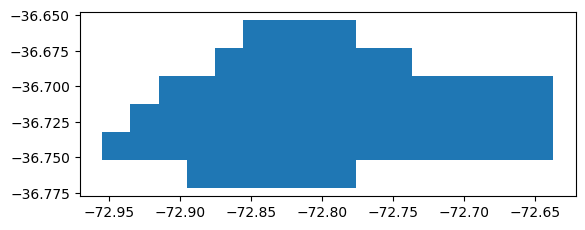

In [50]:
grid = gpd.GeoDataFrame({'geometry':geoms})
geoms

image_paths = []
ID = []
index = 1
eliminar_contenido_carpeta('./subimagenes/')
for sq in geoms:
  xx, yy = sq.exterior.coords.xy
  x = xx.tolist()
  y = yy.tolist()

  url, direccion_imagen = descargar_imagen_sentinel(list(zip(x,y)), "2018-01-01","2019-01-01", "True Color",'./subimagenes', index)
  
  image_paths.append(direccion_imagen)
  ID.append(index)
  print(f"Imagen {index}: {url}")
  index = index + 1

grid.plot();
#image_paths


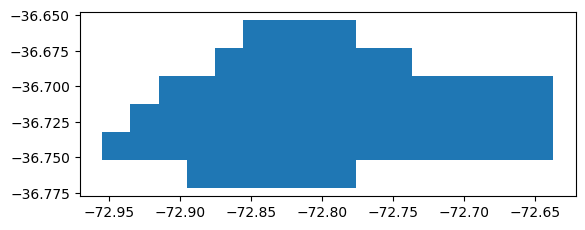

In [51]:
grid.plot();

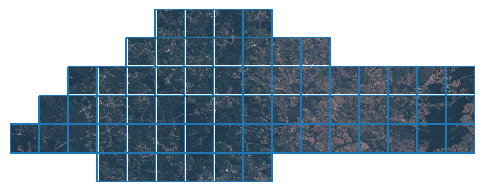

In [52]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


gdf = gpd.GeoDataFrame({'ID':ID,'geometry':geoms,  'image_path': image_paths})

# Cargar las imágenes en una lista
images = [plt.imread(image_path) for image_path in gdf['image_path']]

# Crear el gráfico de GeoDataFrame
fig, ax = plt.subplots(figsize=(6, 6))
gdf.boundary.plot(ax=ax)  # Dibujar los límites de los polígonos

# Iterar a través de los polígonos y agregar imágenes
for x, y, image in zip(gdf.geometry.centroid.x, gdf.geometry.centroid.y, images):
    imagebox = OffsetImage(image, zoom=0.038)  # Ajusta el valor de zoom según sea necesario
    ab = AnnotationBbox(imagebox, (x, y), frameon=False, pad=0)
    ax.add_artist(ab)

ax.set_xlim(gdf.total_bounds[0], gdf.total_bounds[2])
ax.set_ylim(gdf.total_bounds[1], gdf.total_bounds[3])
ax.set_axis_off()
plt.savefig('imagen_original.png', dpi=300, bbox_inches='tight')

plt.show()